In [66]:
from scikits.odes.ode import ode
from GPyOpt.methods import BayesianOptimization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns


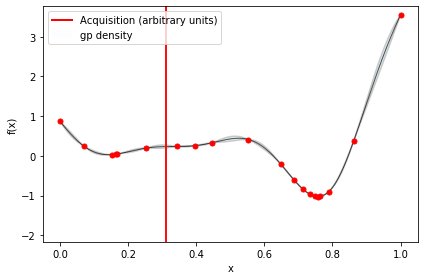

In [3]:
#TOY EXAMPLE
# --- Load GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np
import matplotlib 

# --- Define your problem
def f(x): return (6*x-2)**2*np.sin(12*x-4)
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=f, domain=domain)
myBopt.run_optimization(max_iter=15)
myBopt.plot_acquisition()

In [21]:
ins = myBopt.get_evaluations()[1].flatten()
outs = myBopt.get_evaluations()[0].flatten()
evals = pd.DataFrame(ins, outs)
print(evals.sort_index())

                  0
0.000000   3.027210
0.070302   0.036834
0.152054  -0.973352
0.165245  -0.917519
0.166493  -0.910324
0.253551  -0.187371
0.344207   0.000554
0.395908   0.096178
0.447317   0.458115
0.552958   0.841782
0.647511  -2.089326
0.687088  -4.022074
0.714134  -5.167210
0.734932  -5.773050
0.748063  -5.976898
0.756342  -6.020302
0.763460  -5.999782
0.789340  -5.427642
0.862730   0.701437
1.000000  15.829732


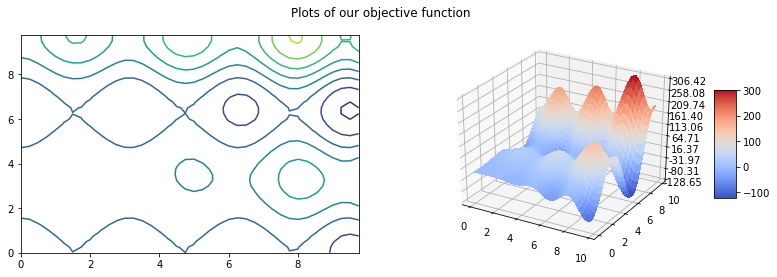

In [30]:
#2-Dimensional Example

def obj_func_2d(x,y):
    return((x**2 + y**2)*(np.sin(x)**2 - np.cos(y)))


fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Plots of our objective function')

# Make data.
X = np.arange(0, 10, 0.25)
Y = np.arange(0, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = obj_func_2d(X,Y)


# First subplot
ax = fig.add_subplot(1, 2, 1)
ax.contour(X,Y,Z)

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [32]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)


def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def dual_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

def upstream_repression(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + k2

def downstream_activation(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = activation(y[1], k2, theta2, n2) + k1

def no_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = k1 + k2

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

In [40]:
def objective(params):
    # Integration conditions
    t = np.linspace(0, 5E4, 100)
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    # Set architecture
    ode_function = downstream_activation

    #Convert space to param values
    param_values = [params[:, 0], params[:, 1], params[:, 2], params[:, 3]]
    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    return loss

domain = [{'name': 'k1', 'type': 'continuous', 'domain': (1E-7,1E-3)}, {'name': 'k2', 'type': 'continuous', 'domain': (1E-7,1E-3)}, 
        {'name': 'theta1', 'type': 'continuous', 'domain': (0.001,10)}, {'name': 'theta2', 'type': 'continuous', 'domain': (0.001,10)}]
maxiter = 500

In [41]:
myBopt_2d = BayesianOptimization(objective, domain=domain)
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()

Value of (x,y) that minimises the objective:[4.44449563e-05 9.35887183e-05 8.64836123e+00 8.51583580e+00]
Minimum value of the objective: 0.06358901044675817


In [60]:
ins = myBopt_2d.get_evaluations()[0]
k1s = ins[:, 0]
k2s = ins[:, 1]
theta1s = ins[:, 2]
theta2s = ins[:, 3]
losses = myBopt_2d.get_evaluations()[1].flatten()
evals = pd.DataFrame({'k1':k1s, 'k2':k2s, 'theta1':theta1s, 'theta2':theta2s, 'loss':losses})
evals.to_csv('gp_500_da.csv')

In [64]:
features = ['k1', 'k2', 'theta1', 'theta2']
landscape = evals
x = landscape.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
landscape['pc1'] = principalComponents[:,0]
landscape['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
landscape['tsne1'] = tsne_results[:,0]
landscape['tsne2'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 505 samples in 0.004s...
[t-SNE] Computed neighbors for 505 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 505 / 505
[t-SNE] Mean sigma: 0.713045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.193638
[t-SNE] KL divergence after 300 iterations: 0.784616


Text(0, 0.5, 'Principal Component 2')

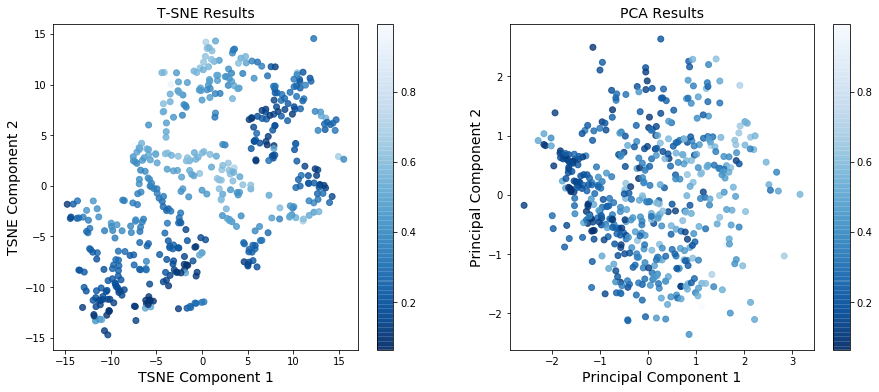

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
contour = ax.scatter(data=landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Blues_r')
fig.colorbar(contour, ax=ax)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
contour = ax.scatter(data=landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Blues_r')
fig.colorbar(contour, ax=ax)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
#fig.savefig('TSNE_PCA_100background_GSperturbations.png')

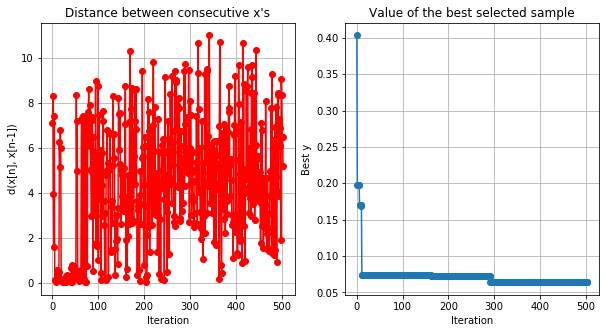

In [42]:
myBopt_2d.plot_convergence()

In [ ]:
import GPyOpt
#Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = domain) 
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

#CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(objective)

# CHOOSE the model type
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

#CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

#CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

#CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [ ]:
# Now create BO object
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

In [3]:
#Stepwise evaluation
bo_step = BayesianOptimization(f = objective, domain = domain, X = X_step, Y = Y_step, acquisition_type = acquisition, 
                                evaluator_type = 'local_penalization', batch_size = batch_size, acquisition_jitter = 0)
x_next = bo_step.suggest_next_locations()

NameError: name 'domain' is not defined

In [76]:
def objective(params):
    # Integration conditions
    t = np.linspace(0, 5E4, 100)
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    # Set architecture
    ode_function = dual_control

    #Convert space to param values
    param_values = [params[:, 0], params[:, 1], params[:, 2], params[:, 3]]
    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    return loss

domain = [{'name': 'k1', 'type': 'continuous', 'domain': (1E-7,1E-3)}, {'name': 'k2', 'type': 'continuous', 'domain': (1E-7,1E-3)}, 
        {'name': 'theta1', 'type': 'continuous', 'domain': (0.001,10)}, {'name': 'theta2', 'type': 'continuous', 'domain': (0.001,10)}]
maxiter = 500

myBopt_2d = BayesianOptimization(objective, domain=domain)
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()

ins = myBopt_2d.get_evaluations()[0]
k1s = ins[:, 0]
k2s = ins[:, 1]
theta1s = ins[:, 2]
theta2s = ins[:, 3]
losses = myBopt_2d.get_evaluations()[1].flatten()
evals = pd.DataFrame({'k1':k1s, 'k2':k2s, 'theta1':theta1s, 'theta2':theta2s, 'loss':losses})
evals.to_csv('gp_500_dc.csv')

Value of (x,y) that minimises the objective:[6.47807551e-04 7.38990508e-05 2.34798899e+00 8.80156140e+00]
Minimum value of the objective: 0.06532712500894297


In [79]:
def objective(params):
    # Integration conditions
    t = np.linspace(0, 5E4, 100)
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    # Set architecture
    ode_function = no_control

    #Convert space to param values
    param_values = [params[:, 0], params[:, 1], params[:, 2], params[:, 3]]
    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    return loss

domain = [{'name': 'k1', 'type': 'continuous', 'domain': (1E-7,1E-3)}, {'name': 'k2', 'type': 'continuous', 'domain': (1E-7,1E-3)}, 
        {'name': 'theta1', 'type': 'continuous', 'domain': (0.001,10)}, {'name': 'theta2', 'type': 'continuous', 'domain': (0.001,10)}]
maxiter = 500

myBopt_2d = BayesianOptimization(objective, domain=domain)
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()

ins = myBopt_2d.get_evaluations()[0]
k1s = ins[:, 0]
k2s = ins[:, 1]
theta1s = ins[:, 2]
theta2s = ins[:, 3]
losses = myBopt_2d.get_evaluations()[1].flatten()
evals = pd.DataFrame({'k1':k1s, 'k2':k2s, 'theta1':theta1s, 'theta2':theta2s, 'loss':losses})
evals.to_csv('gp_500_nc.csv')

Value of (x,y) that minimises the objective:[5.06625508e-05 8.93571024e-05 1.34490112e-01 2.90968093e+00]
Minimum value of the objective: 0.0896468382529483


In [78]:
def objective(params):
    # Integration conditions
    t = np.linspace(0, 5E4, 100)
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    # Set architecture
    ode_function = upstream_repression

    #Convert space to param values
    param_values = [params[:, 0], params[:, 1], params[:, 2], params[:, 3]]
    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    return loss

domain = [{'name': 'k1', 'type': 'continuous', 'domain': (1E-7,1E-3)}, {'name': 'k2', 'type': 'continuous', 'domain': (1E-7,1E-3)}, 
        {'name': 'theta1', 'type': 'continuous', 'domain': (0.001,10)}, {'name': 'theta2', 'type': 'continuous', 'domain': (0.001,10)}]
maxiter = 500

myBopt_2d = BayesianOptimization(objective, domain=domain)
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()

ins = myBopt_2d.get_evaluations()[0]
k1s = ins[:, 0]
k2s = ins[:, 1]
theta1s = ins[:, 2]
theta2s = ins[:, 3]
losses = myBopt_2d.get_evaluations()[1].flatten()
evals = pd.DataFrame({'k1':k1s, 'k2':k2s, 'theta1':theta1s, 'theta2':theta2s, 'loss':losses})
evals.to_csv('gp_500_ur.csv')

Value of (x,y) that minimises the objective:[1.37511028e-04 2.86082252e-05 7.78724552e+00 1.00000000e+01]
Minimum value of the objective: 0.07070006262365923


In [80]:
ur_evals = pd.read_csv('gp_500_ur.csv')
ur_evals['circuit'] = 'Upstream Repression'
da_evals = pd.read_csv('gp_500_da.csv')
dc_evals = pd.read_csv('gp_500_dc.csv')
dc_evals['circuit'] = 'Dual Control'
da_evals['circuit'] = 'Downstream Activation'
nc_evals = pd.read_csv('gp_500_nc.csv')
nc_evals['circuit'] = 'No Control'
landscape = pd.concat([ur_evals, dc_evals, da_evals, nc_evals])

In [99]:
features = ['k1', 'k2', 'theta1', 'theta2']
x = landscape.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
landscape['pc1'] = principalComponents[:,0]
landscape['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
landscape['tsne1'] = tsne_results[:,0]
landscape['tsne2'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2020 samples in 0.001s...
[t-SNE] Computed neighbors for 2020 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2020
[t-SNE] Computed conditional probabilities for sample 2000 / 2020
[t-SNE] Computed conditional probabilities for sample 2020 / 2020
[t-SNE] Mean sigma: 0.014814
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.940231
[t-SNE] KL divergence after 300 iterations: 1.109918


In [100]:
dc_landscape = landscape.loc[landscape.circuit == 'Dual Control']
da_landscape = landscape.loc[landscape.circuit == 'Downstream Activation']
nc_landscape = landscape.loc[landscape.circuit == 'No Control']
ur_landscape = landscape.loc[landscape.circuit == 'Upstream Repression']

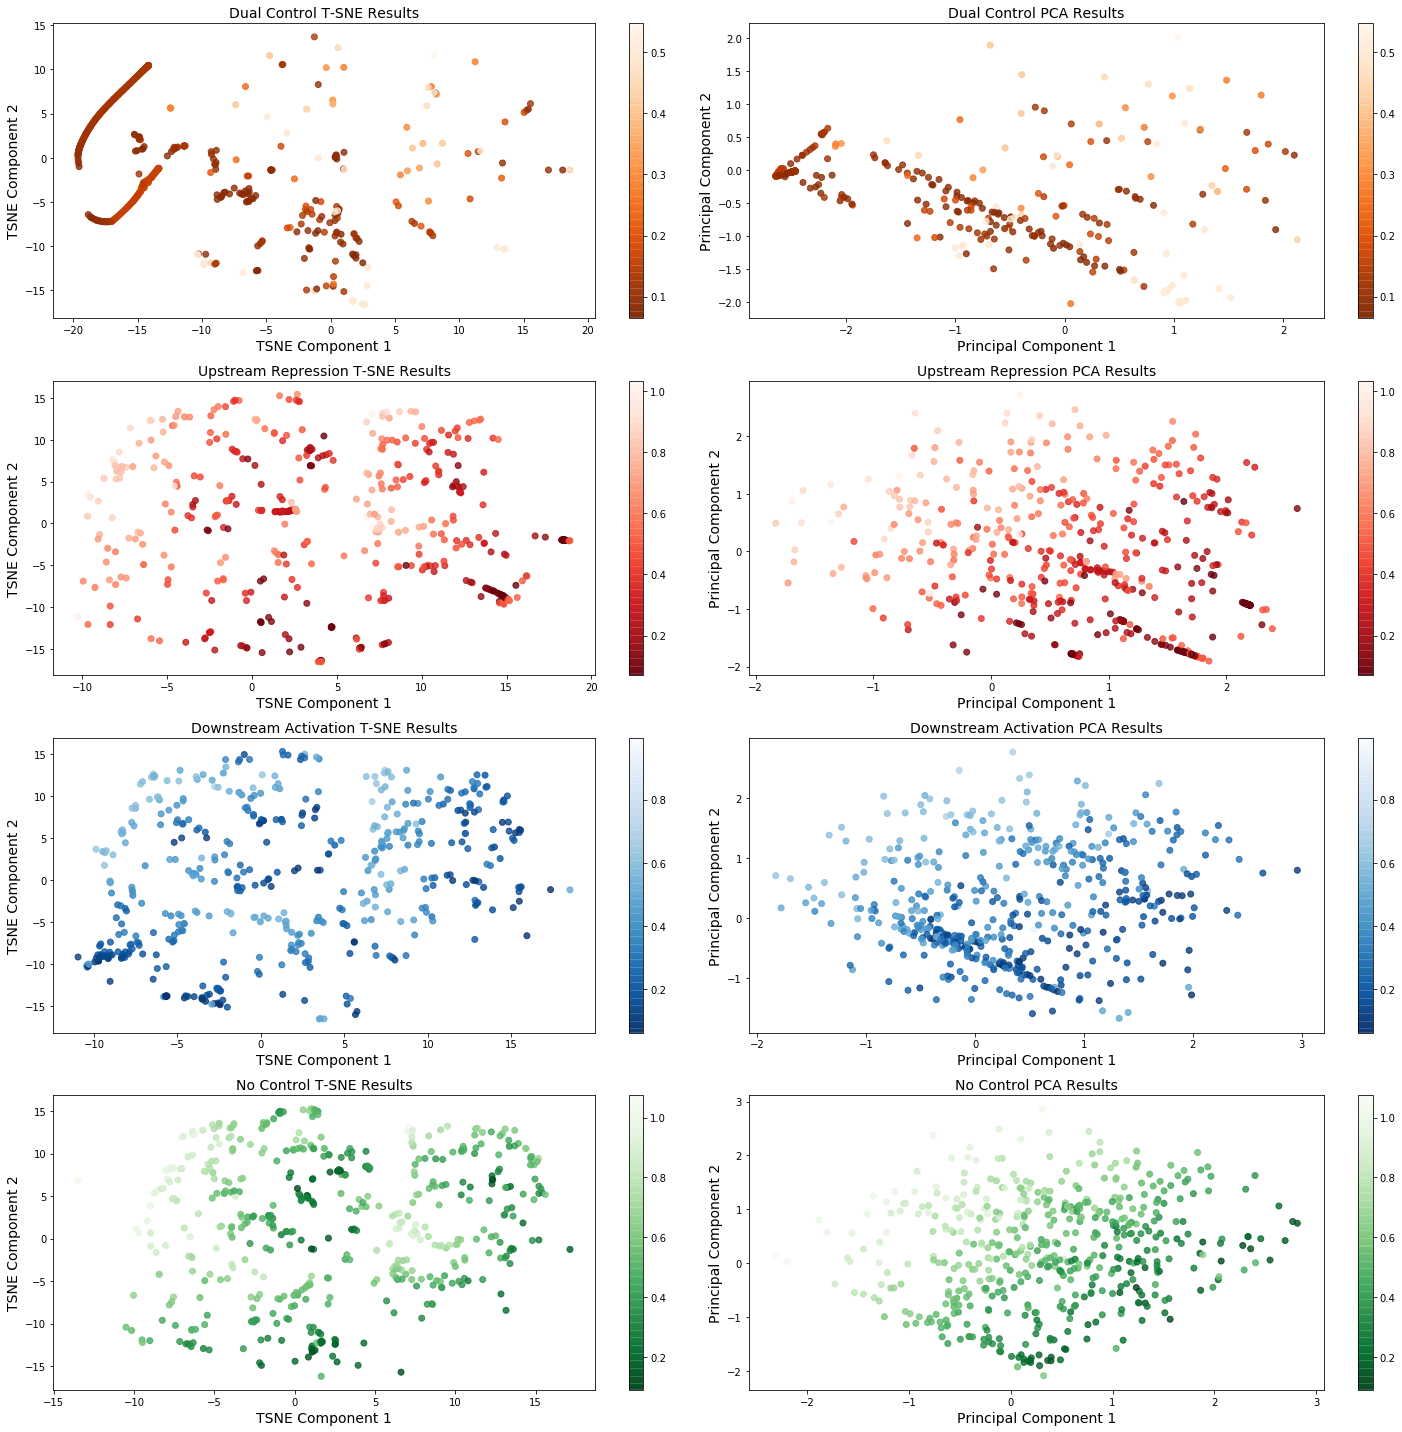

In [109]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

endpoint = 'Dual Control T-SNE Results'
ax = axs[0][0]
contour = ax.scatter(data=dc_landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Oranges_r')
fig.colorbar(contour, ax=ax)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)

endpoint = 'Upstream Repression T-SNE Results'
ax = axs[1][0]
contour = ax.scatter(data=ur_landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Reds_r')
fig.colorbar(contour, ax=ax)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)

endpoint = 'Downstream Activation T-SNE Results'
ax = axs[2][0]
contour = ax.scatter(data=da_landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Blues_r')
fig.colorbar(contour, ax=ax)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)

endpoint = 'No Control T-SNE Results'
ax = axs[3][0]
contour = ax.scatter(data=nc_landscape, x="tsne1", y="tsne2", alpha = .8, c = 'loss', cmap = 'Greens_r')
fig.colorbar(contour, ax=ax)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)






endpoint = 'Dual Control PCA Results'
ax = axs[0][1]
contour = ax.scatter(data=dc_landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Oranges_r')
fig.colorbar(contour, ax=ax, fraction=0.1)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)



endpoint = 'Downstream Activation PCA Results'
ax = axs[2][1]
contour = ax.scatter(data=da_landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Blues_r')
fig.colorbar(contour, ax=ax, fraction=0.1)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)


endpoint = 'Upstream Repression PCA Results'
ax = axs[1][1]
contour = ax.scatter(data=ur_landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Reds_r')
fig.colorbar(contour, ax=ax, fraction=0.1)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)


endpoint = 'No Control PCA Results'
ax = axs[3][1]
contour = ax.scatter(data=nc_landscape, x="pc1", y="pc2", alpha = .8, c = 'loss', cmap = 'Greens_r')
fig.colorbar(contour, ax=ax, fraction=0.1)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)







fig.tight_layout()